In [1]:
import os
import cv2
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import pandas as pd
import random
from glob import glob
from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn import metrics
from sklearn.model_selection import KFold

# import要訓練的 model
from MRSKNet import MRSKNet
from ResNet import BasicResNet
from SKNet import BasicSKNet
from LocalGlobalNet import LocalGlobalNetwork

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_folder = "/home/cbel/Desktop/zhe/data"

In [2]:
def load_data(df, index, imgs_path, augment=False):
    imgs = {}
    labels = {}
    for i in range(len(imgs_path)):
        if augment:
            num = int(imgs_path[i][-11:-7])
        else:
            num = int(imgs_path[i][-8:-4])
        if num in index:
            if num not in imgs:
                imgs[num] = []
                labels[num] = int(df[df["nodule_number"]==num]["malignancy"])
            img = np.load(imgs_path[i])
            img = img / 255.0
            imgs[num].append(img)
    return imgs, labels

def generate_data(imgs, labels, index):
    train_imgs = []
    train_labels = []
    for key in index:
        for i in range(len(imgs[key])):
            train_imgs.append(imgs[key][i])
            train_labels.append(labels[key])
    train_imgs = np.array(train_imgs)
    train_labels = np.array(train_labels)
    train_labels = train_labels[:, np.newaxis]
    return train_imgs, train_labels

In [3]:
def train(train_loader, val_loader, model, lr, epochs):
    set_randomSeed()
    start = time.time()
    if torch.cuda.device_count() > 1:
        print("Let's use %d GPUs!" %torch.cuda.device_count())
        model = nn.DataParallel(model)
    
    model.to(device)
    print("parameter numbers:", sum(param.numel() for param in model.parameters()))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss = nn.BCELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

    his_train_loss = []
    his_val_loss = []
    best_metrics = 0.0
    best_auc = 0.0
    best_acc = 0.0
    best_recall = 0.0
    log = ""
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        preds_list = []
        labels_list = []

        train_loss = 0
        train_auc = 0
        train_acc = 0
        train_recall = 0
        train_specificity = 0
        train_precision = 0
        train_len = train_loader.__len__()

        val_loss = 0
        val_auc = 0
        val_acc = 0
        val_recall = 0
        val_specificity = 0
        val_precision = 0
        val_len = val_loader.__len__()

        model.train()
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            preds = model(inputs)
            batch_loss = loss(preds, labels)
            batch_loss.backward()
            optimizer.step()

            preds = preds.data.cpu().numpy()
            labels = labels.data.cpu().numpy()

            train_loss += batch_loss.item()
            if len(np.unique(labels)) == 2:
                train_auc += metrics.roc_auc_score(labels, preds)
            preds[preds > 0.5] = 1
            preds[preds != 1] = 0
            confusion = metrics.confusion_matrix(labels, preds)
            TP = confusion[1, 1]
            TN = confusion[0, 0]
            FP = confusion[0, 1]
            FN = confusion[1, 0]
            train_acc += ((TP + TN) / (TP + TN + FP + FN))
            train_recall += ((TP) / (TP + FN))
            train_specificity += ((TN) / (TN + FP))
            train_precision += ((TP) / (TP + FP))

        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                inputs = batch[0].to(device)
                labels = batch[1].to(device)
                preds = model(inputs)
                batch_loss = loss(preds, labels)

                preds = preds.data.cpu().numpy()
                labels = labels.data.cpu().numpy()
                preds_list.extend(preds.copy())
                labels_list.extend(labels.copy())

                val_loss += batch_loss.item()
                if len(np.unique(labels)) == 2:
                    val_auc += metrics.roc_auc_score(labels, preds)
                preds[preds > 0.5] = 1
                preds[preds != 1] = 0
                confusion = metrics.confusion_matrix(labels, preds)
                TP = confusion[1, 1]
                TN = confusion[0, 0]
                FP = confusion[0, 1]
                FN = confusion[1, 0]
                val_acc += ((TP + TN) / (TP + TN + FP + FN))
                val_recall += ((TP) / (TP + FN))
                val_specificity += ((TN) / (TN + FP))
                val_precision += ((TP) / (TP + FP))

        train_loss = train_loss / train_len
        train_auc = train_auc / train_len
        train_acc = train_acc / train_len
        train_recall = train_recall / train_len
        train_specificity = train_specificity / train_len
        train_precision = train_precision / train_len
        val_loss = val_loss / val_len
        val_auc = val_auc / val_len
        val_acc = val_acc / val_len
        val_recall = val_recall / val_len
        val_specificity = val_specificity / val_len
        val_precision = val_precision / val_len
        his_train_loss.append(train_loss)
        his_val_loss.append(val_loss)
        fpr, tpr, _ = metrics.roc_curve(labels_list, preds_list, drop_intermediate=False)

        scheduler.step()

        if val_auc + val_acc + val_recall >= best_metrics:
            roc = []
            roc.append(fpr)
            roc.append(tpr)
            roc.append(val_auc)
            best_metrics = val_auc + val_acc + val_recall
            best = [val_auc, val_acc, val_recall, val_specificity, val_precision, epoch+1]

        print(f"[{epoch+1:03d}/{epochs:03d}] {time.time()-epoch_start_time:2.2f}(s) \
Train Loss: {train_loss:.4f} AUC: {train_auc:.4f} ACC: {train_acc:.4f} | \
Val loss: {val_loss:.4f} AUC: {val_auc:.4f} ACC: {val_acc:.4f}")
        log += f"[{epoch+1:03d}/{epochs:03d}] {time.time()-epoch_start_time:2.2f}(s)\
Train Loss: {train_loss:.4f} AUC: {train_auc:.4f} ACC: {train_acc:.4f} | \
Val loss: {val_loss:.4f} AUC: {val_auc:.4f} ACC: {val_acc:.4f} \n"

    end = time.time()
    total_time = end - start
    print(total_time)
    print(f"Time : {int(total_time // 60)} m {int(total_time % 60)} s")
    print(f"BEST RESULT --> AUC:{best[0]:.4f}  ACC:{best[1]:.4f}  Recall:{best[2]:.4f}\
  Specificity:{best[3]:.4f} Precision:{best[4]:.4f}  Epoch:{best[5]}")
    log += f"BEST RESULT --> AUC:{best[0]:.4f}  ACC:{best[1]:.4f}  Recall:{best[2]:.4f}\
  Specificity:{best[3]:.4f} Precision:{best[4]:.4f}  Epoch:{best[5]} \n"
    return best, roc, [his_train_loss, his_val_loss], log

In [4]:
import warnings
warnings.filterwarnings("ignore")

dataset = "original"
log = ""

all_metric = []
df = pd.read_csv(data_folder + "/final_annotation.csv")
df = df[df["malignancy"]!=2]
index = df["nodule_number"].values

imgs_path = glob(data_folder + f'/multi_view/{dataset}/*.npy')
imgs_path.sort()
imgs, labels = load_data(df, index, imgs_path)

aug_path = glob(data_folder + f'/augment/{dataset}/*.npy')
aug_path.sort()
aug_imgs, aug_labels = load_data(df, index, aug_path, True)

print(f"Input dimension: {imgs[1][0].shape}")

with open(data_folder + "/tenFold.pickle", "rb") as f:
    tenFold = pickle.load(f)    

all_roc = []
all_his_loss = []
for i in range(10):
    train_index = tenFold[i]["train"]
    val_index = tenFold[i]["val"]
    print(f"-----fold {i+1}-----")
    log += f"fold {i+1}\n"
    
    train_imgs, train_labels = generate_data(aug_imgs, aug_labels, train_index)
    val_imgs, val_labels = generate_data(imgs, labels, val_index)     
    
    unique, counts = np.unique(train_labels, return_counts=True)
    train_distribution = dict(zip(unique, counts))
    unique, counts = np.unique(val_labels, return_counts=True)
    val_distribution = dict(zip(unique, counts))

    print(f"Train distribution: {train_distribution}  Total number: {len(train_imgs)}")
    print(f"Val distribution:   {val_distribution}      Total number: {len(val_imgs)}")

    train_imgs = torch.FloatTensor(train_imgs)
    train_labels = torch.FloatTensor(train_labels)
    val_imgs = torch.FloatTensor(val_imgs)
    val_labels = torch.FloatTensor(val_labels)

    set_randomSeed()

    train_set = TensorDataset(train_imgs, train_labels)
    val_set = TensorDataset(val_imgs, val_labels)
    
    batch_size = 256
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    batch_size = 64
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
    
    fold_metric, roc, his_loss, log2 = train(train_loader=train_loader, val_loader=val_loader, 
                                             model=MRSKNet(), lr=1e-4, epochs=50)
    log += log2
    all_metric.append(fold_metric[:5])
    all_roc.append(roc)
    all_his_loss.append(his_loss)
final_metric = np.mean(all_metric, axis=0)
print(f"FINAL RESULT --> AUC: {final_metric[0]:.4f}  ACC: {final_metric[1]:.4f}  Recall: {final_metric[2]:.4f}\
  Specificity: {final_metric[3]:.4f}  Precision: {final_metric[4]:.4f}")
log += f"FINAL RESULT --> AUC: {final_metric[0]:.4f}  ACC: {final_metric[1]:.4f}  Recall: {final_metric[2]:.4f}\
  Specificity: {final_metric[3]:.4f}  Precision: {final_metric[4]:.4f}"

Input dimension: (3, 2, 32, 32)
-----fold 1-----
Train distribution: {0: 6432, 1: 6192}  Total number: 12624
Val distribution:   {0: 45, 1: 43}      Total number: 88
parameter numbers: 35041
[001/050] 2.08(s) Train Loss: 0.7841 AUC: 0.6761 ACC: 0.6296 | Val loss: 0.4393 AUC: 0.8919 ACC: 0.8151
[002/050] 1.70(s) Train Loss: 0.5587 AUC: 0.8180 ACC: 0.7510 | Val loss: 0.4542 AUC: 0.8632 ACC: 0.8021
[003/050] 1.68(s) Train Loss: 0.4713 AUC: 0.8683 ACC: 0.8033 | Val loss: 0.4218 AUC: 0.9052 ACC: 0.7891
[004/050] 1.69(s) Train Loss: 0.4197 AUC: 0.8970 ACC: 0.8275 | Val loss: 0.4373 AUC: 0.8904 ACC: 0.8307
[005/050] 1.68(s) Train Loss: 0.3981 AUC: 0.9082 ACC: 0.8388 | Val loss: 0.4315 AUC: 0.8969 ACC: 0.8203
[006/050] 1.68(s) Train Loss: 0.3756 AUC: 0.9185 ACC: 0.8510 | Val loss: 0.3619 AUC: 0.9100 ACC: 0.8750
[007/050] 1.68(s) Train Loss: 0.3604 AUC: 0.9254 ACC: 0.8591 | Val loss: 0.4383 AUC: 0.9198 ACC: 0.8542
[008/050] 1.69(s) Train Loss: 0.3379 AUC: 0.9339 ACC: 0.8695 | Val loss: 0.4519 A

[026/050] 1.68(s) Train Loss: 0.2618 AUC: 0.9593 ACC: 0.8967 | Val loss: 0.2436 AUC: 0.9522 ACC: 0.8568
[027/050] 1.69(s) Train Loss: 0.2610 AUC: 0.9590 ACC: 0.9006 | Val loss: 0.2120 AUC: 0.9673 ACC: 0.9245
[028/050] 1.68(s) Train Loss: 0.2626 AUC: 0.9586 ACC: 0.8969 | Val loss: 0.3584 AUC: 0.9355 ACC: 0.8724
[029/050] 1.68(s) Train Loss: 0.2612 AUC: 0.9591 ACC: 0.8982 | Val loss: 0.2831 AUC: 0.9462 ACC: 0.8984
[030/050] 1.67(s) Train Loss: 0.2666 AUC: 0.9571 ACC: 0.8970 | Val loss: 0.2608 AUC: 0.9490 ACC: 0.9115
[031/050] 1.69(s) Train Loss: 0.2585 AUC: 0.9600 ACC: 0.8982 | Val loss: 0.2512 AUC: 0.9520 ACC: 0.9089
[032/050] 1.66(s) Train Loss: 0.2590 AUC: 0.9597 ACC: 0.8993 | Val loss: 0.2942 AUC: 0.9502 ACC: 0.8854
[033/050] 1.67(s) Train Loss: 0.2580 AUC: 0.9598 ACC: 0.8991 | Val loss: 0.2528 AUC: 0.9383 ACC: 0.9036
[034/050] 1.66(s) Train Loss: 0.2612 AUC: 0.9597 ACC: 0.8962 | Val loss: 0.3228 AUC: 0.9398 ACC: 0.8698
[035/050] 1.69(s) Train Loss: 0.2605 AUC: 0.9592 ACC: 0.8980 | V

[001/050] 1.67(s) Train Loss: 0.7839 AUC: 0.6770 ACC: 0.6303 | Val loss: 0.4478 AUC: 0.8822 ACC: 0.8151
[002/050] 1.69(s) Train Loss: 0.5648 AUC: 0.8137 ACC: 0.7461 | Val loss: 0.3423 AUC: 0.9279 ACC: 0.8646
[003/050] 1.68(s) Train Loss: 0.4777 AUC: 0.8657 ACC: 0.7967 | Val loss: 0.3267 AUC: 0.9455 ACC: 0.8594
[004/050] 1.67(s) Train Loss: 0.4353 AUC: 0.8896 ACC: 0.8219 | Val loss: 0.3293 AUC: 0.9380 ACC: 0.8490
[005/050] 1.69(s) Train Loss: 0.4117 AUC: 0.9018 ACC: 0.8350 | Val loss: 0.2955 AUC: 0.9559 ACC: 0.8594
[006/050] 1.68(s) Train Loss: 0.3918 AUC: 0.9113 ACC: 0.8468 | Val loss: 0.3311 AUC: 0.9537 ACC: 0.8542
[007/050] 1.67(s) Train Loss: 0.3761 AUC: 0.9191 ACC: 0.8509 | Val loss: 0.2925 AUC: 0.9426 ACC: 0.8620
[008/050] 1.67(s) Train Loss: 0.3559 AUC: 0.9266 ACC: 0.8626 | Val loss: 0.2515 AUC: 0.9675 ACC: 0.8724
[009/050] 1.66(s) Train Loss: 0.3457 AUC: 0.9299 ACC: 0.8646 | Val loss: 0.2652 AUC: 0.9647 ACC: 0.8854
[010/050] 1.70(s) Train Loss: 0.3373 AUC: 0.9339 ACC: 0.8688 | V

[027/050] 1.68(s) Train Loss: 0.2579 AUC: 0.9603 ACC: 0.9000 | Val loss: 0.2044 AUC: 0.9712 ACC: 0.9375
[028/050] 1.68(s) Train Loss: 0.2542 AUC: 0.9611 ACC: 0.8987 | Val loss: 0.2562 AUC: 0.9591 ACC: 0.8984
[029/050] 1.68(s) Train Loss: 0.2595 AUC: 0.9596 ACC: 0.8987 | Val loss: 0.2516 AUC: 0.9736 ACC: 0.9193
[030/050] 1.67(s) Train Loss: 0.2588 AUC: 0.9599 ACC: 0.8979 | Val loss: 0.2248 AUC: 0.9680 ACC: 0.9323
[031/050] 1.70(s) Train Loss: 0.2555 AUC: 0.9610 ACC: 0.8988 | Val loss: 0.2102 AUC: 0.9695 ACC: 0.9323
[032/050] 1.67(s) Train Loss: 0.2539 AUC: 0.9611 ACC: 0.9007 | Val loss: 0.2299 AUC: 0.9657 ACC: 0.9193
[033/050] 1.73(s) Train Loss: 0.2528 AUC: 0.9613 ACC: 0.8993 | Val loss: 0.2511 AUC: 0.9427 ACC: 0.9323
[034/050] 1.67(s) Train Loss: 0.2588 AUC: 0.9602 ACC: 0.8975 | Val loss: 0.2171 AUC: 0.9705 ACC: 0.9323
[035/050] 1.72(s) Train Loss: 0.2570 AUC: 0.9602 ACC: 0.8988 | Val loss: 0.3005 AUC: 0.9484 ACC: 0.9062
[036/050] 1.68(s) Train Loss: 0.2552 AUC: 0.9611 ACC: 0.8986 | V

[001/050] 1.69(s) Train Loss: 0.7851 AUC: 0.6783 ACC: 0.6308 | Val loss: 0.4765 AUC: 0.8484 ACC: 0.7448
[002/050] 1.69(s) Train Loss: 0.5485 AUC: 0.8218 ACC: 0.7532 | Val loss: 0.5375 AUC: 0.8330 ACC: 0.7031
[003/050] 1.68(s) Train Loss: 0.4628 AUC: 0.8738 ACC: 0.8040 | Val loss: 0.4176 AUC: 0.9198 ACC: 0.7630
[004/050] 1.66(s) Train Loss: 0.4260 AUC: 0.8952 ACC: 0.8246 | Val loss: 0.3772 AUC: 0.9353 ACC: 0.7708
[005/050] 1.67(s) Train Loss: 0.3977 AUC: 0.9080 ACC: 0.8411 | Val loss: 0.4275 AUC: 0.9111 ACC: 0.7552
[006/050] 1.70(s) Train Loss: 0.3801 AUC: 0.9164 ACC: 0.8503 | Val loss: 0.3538 AUC: 0.9390 ACC: 0.8151
[007/050] 1.67(s) Train Loss: 0.3621 AUC: 0.9249 ACC: 0.8591 | Val loss: 0.3089 AUC: 0.9450 ACC: 0.8438
[008/050] 1.68(s) Train Loss: 0.3405 AUC: 0.9324 ACC: 0.8662 | Val loss: 0.4285 AUC: 0.9010 ACC: 0.7839
[009/050] 1.69(s) Train Loss: 0.3333 AUC: 0.9357 ACC: 0.8707 | Val loss: 0.3959 AUC: 0.9056 ACC: 0.7839
[010/050] 1.69(s) Train Loss: 0.3226 AUC: 0.9398 ACC: 0.8768 | V

[027/050] 1.69(s) Train Loss: 0.2601 AUC: 0.9591 ACC: 0.8973 | Val loss: 0.2807 AUC: 0.9581 ACC: 0.8879
[028/050] 1.68(s) Train Loss: 0.2583 AUC: 0.9592 ACC: 0.9000 | Val loss: 0.2752 AUC: 0.9592 ACC: 0.9158
[029/050] 1.71(s) Train Loss: 0.2585 AUC: 0.9594 ACC: 0.9007 | Val loss: 0.2643 AUC: 0.9702 ACC: 0.9018
[030/050] 1.68(s) Train Loss: 0.2570 AUC: 0.9603 ACC: 0.9027 | Val loss: 0.3973 AUC: 0.9453 ACC: 0.8723
[031/050] 1.68(s) Train Loss: 0.2568 AUC: 0.9601 ACC: 0.9000 | Val loss: 0.3900 AUC: 0.9346 ACC: 0.8879
[032/050] 1.69(s) Train Loss: 0.2556 AUC: 0.9605 ACC: 0.9018 | Val loss: 0.3027 AUC: 0.9593 ACC: 0.8662
[033/050] 1.68(s) Train Loss: 0.2527 AUC: 0.9616 ACC: 0.9016 | Val loss: 0.2891 AUC: 0.9512 ACC: 0.9018
[034/050] 1.68(s) Train Loss: 0.2576 AUC: 0.9600 ACC: 0.8998 | Val loss: 0.2613 AUC: 0.9582 ACC: 0.9158
[035/050] 1.68(s) Train Loss: 0.2585 AUC: 0.9599 ACC: 0.9030 | Val loss: 0.2517 AUC: 0.9640 ACC: 0.9158
[036/050] 1.69(s) Train Loss: 0.2569 AUC: 0.9602 ACC: 0.9008 | V

[001/050] 1.68(s) Train Loss: 0.8062 AUC: 0.6631 ACC: 0.6146 | Val loss: 0.4115 AUC: 0.9271 ACC: 0.8271
[002/050] 1.70(s) Train Loss: 0.5608 AUC: 0.8165 ACC: 0.7506 | Val loss: 0.3268 AUC: 0.9426 ACC: 0.8784
[003/050] 1.67(s) Train Loss: 0.4897 AUC: 0.8600 ACC: 0.7893 | Val loss: 0.3459 AUC: 0.9321 ACC: 0.8662
[004/050] 1.66(s) Train Loss: 0.4420 AUC: 0.8863 ACC: 0.8146 | Val loss: 0.3358 AUC: 0.9284 ACC: 0.8801
[005/050] 1.67(s) Train Loss: 0.4112 AUC: 0.9021 ACC: 0.8358 | Val loss: 0.2684 AUC: 0.9582 ACC: 0.8940
[006/050] 1.67(s) Train Loss: 0.3964 AUC: 0.9111 ACC: 0.8408 | Val loss: 0.2014 AUC: 0.9782 ACC: 0.9297
[007/050] 1.67(s) Train Loss: 0.3779 AUC: 0.9165 ACC: 0.8482 | Val loss: 0.2621 AUC: 0.9916 ACC: 0.8740
[008/050] 1.69(s) Train Loss: 0.3634 AUC: 0.9242 ACC: 0.8564 | Val loss: 0.2066 AUC: 0.9869 ACC: 0.9096
[009/050] 1.68(s) Train Loss: 0.3498 AUC: 0.9297 ACC: 0.8604 | Val loss: 0.1817 AUC: 0.9888 ACC: 0.9392
[010/050] 1.68(s) Train Loss: 0.3429 AUC: 0.9312 ACC: 0.8668 | V

In [5]:
filename = "MRSKNet"
f = open(data_folder + f"/other/{filename}.txt", "w")
f.write(log)
f.close()

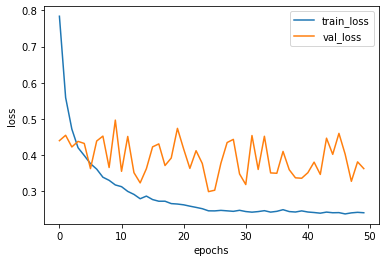

In [6]:
fold = 0
his_train_loss = all_his_loss[fold][0]
his_val_loss = all_his_loss[fold][1]
plot(his_train_loss, his_val_loss, "loss", True)

In [7]:
def get_mean_roc(all_roc):
    roc = all_roc.copy()
    max_len = 0
    for r in roc:
        if len(r[0]) > max_len:
            max_len = len(r[0])
    for i in range(10):
        diff = max_len - len(roc[i][0])
        if diff != 0:
            for j in range(diff):
                roc[i][0] = np.insert(roc[i][0], max_len//2, (roc[i][0][(max_len//2)-1]+roc[i][0][max_len//2])/2)
                roc[i][1] = np.insert(roc[i][1], max_len//2, (roc[i][1][(max_len//2)-1]+roc[i][1][max_len//2])/2)
    return np.mean(roc, axis=0)
mroc = get_mean_roc(all_roc)

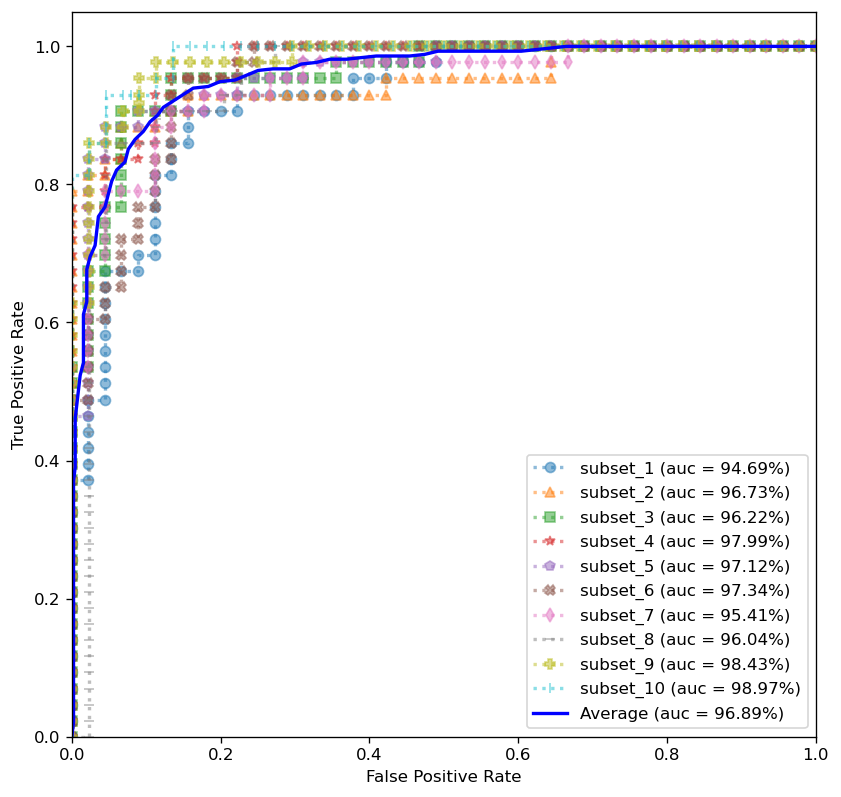

In [9]:
markers = ["o", "^", "s", "*", "p", "X", "d", "_", "P", "|"]
plt.figure(figsize=(8, 8), dpi=120)
lw = 2
for i in range(10):
    plt.plot(all_roc[i][0], all_roc[i][1], alpha=0.5, lw=lw, linestyle="dotted", marker=markers[i],
             label=f'subset_{i+1} (auc = {all_roc[i][2]*100:.2f}%)')
plt.plot(mroc[0], mroc[1], color="blue", lw=lw, label=f'Average (auc = {mroc[2]*100:.2f}%)')
plt.plot()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(data_folder + "/other/auc_MRSKNet.tiff")
plt.show()